In [1]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import random
import math
import torch.nn.functional as F
from aircraft import Aircraft

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

In [3]:
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return  out


In [4]:
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock]
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_downsample =  nn.Sequential(
                nn.Conv2d(
                    512, 
                    128,
                    kernel_size=1,
                    stride=1,
                    bias=False 
                ),
                nn.BatchNorm2d(128)
            )
        # self.fc = nn.Linear(512, 128)

    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.final_downsample(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [5]:
class Net_NW_Head(nn.Module):

    def __init__(self, classes, device):
        self.device = device
        super(Net_NW_Head, self).__init__()
        self.rs18 = ResNet(img_channels=3, num_layers=18, block=BasicBlock)
        self.classes = classes
        self.eps = 1e-5
        
    def set_support(self, support_element_imgs, support_labels):
        self.support_element_imgs = support_element_imgs
        self.support_labels_one_hot = torch.tensor(np.eye(self.classes)[support_labels], requires_grad=True).to(device)

    def apply_kernel(self, x):
        raw_distances = torch.exp(-torch.cdist(x, self.support_elements))
        raw_distances = raw_distances + self.eps
        distances = raw_distances / raw_distances.sum(dim=-1).unsqueeze(-1)
        result = []
        for i in range(distances.shape[0]):
            result.append((distances[i].unsqueeze(1) * self.support_labels_one_hot).sum(dim = 0).unsqueeze(0))
        result = torch.cat(result)
        return result

    def forward(self, x):
        x = self.rs18(x)
        self.support_elements = self.rs18(self.support_element_imgs)
        x = self.apply_kernel(x)
        x = x + self.eps
        x = torch.log(x)
        return x


In [6]:
plt.style.use('ggplot')
IMG_SIZE = 224

def get_data(batch_size=64):

    dataset_train = Aircraft('./data',
        train=True,
        download=True,
        transform=transforms.Compose([
              transforms.Resize((IMG_SIZE,IMG_SIZE)),
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomVerticalFlip(p=0.3),
              transforms.RandomRotation(degrees=(-15, 15)),
              transforms.ToTensor()
           ])
    )
    dataset_valid = Aircraft('./data',
         train=False,
         download=True,
         transform=transforms.Compose([
              transforms.Resize((IMG_SIZE,IMG_SIZE)),
              transforms.ToTensor()
           ])
    )
    train_loader = DataLoader(
        dataset_train, 
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid, 
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, valid_loader, dataset_train, dataset_valid
  

In [22]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.savefig(os.path.join('outputs', name+'_accuracy.png'))
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_loss.png'))

In [8]:
SUPPORT_SIZE = 3

def train(model, trainloader, optimizer, criterion, device, full_support_set):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):

        support_elements_temp = []
        support_labels = []
        for label in full_support_set.keys():
            support_elements_temp.extend(random.sample(full_support_set[label], SUPPORT_SIZE))
            support_labels.extend([label for i in range(SUPPORT_SIZE)])

        img_shape = support_elements_temp[0].shape
        support_elements_ng = torch.zeros((len(support_elements_temp), img_shape[0], img_shape[1], img_shape[2]))
        for i in range(len(support_elements_temp)):
          support_elements_ng[i] = support_elements_temp[i]

        support_elements = support_elements_ng.clone().detach().requires_grad_(True)
        support_elements = support_elements.to(device)

        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # support
        model.set_support(support_elements, support_labels)

        outputs = model(image)

        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device, full_support_set):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):

            support_elements_temp = []
            support_labels = []
            for label in full_support_set.keys():
                support_elements_temp.extend(random.sample(full_support_set[label], SUPPORT_SIZE))
                support_labels.extend([label for i in range(SUPPORT_SIZE)])

            img_shape = support_elements_temp[0].shape
            support_elements = torch.zeros((len(support_elements_temp), img_shape[0], img_shape[1], img_shape[2]))
            for i in range(len(support_elements_temp)):
                support_elements[i] = support_elements_temp[i]

            support_elements = support_elements.to(device)

            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # support
            model.set_support(support_elements, support_labels)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [9]:

epochs = 350
batch_size = 16
learning_rate = 0.001
momentum = 0.9
classes = 100

device = torch.device("cuda:6" if torch.cuda.is_available() else 'cpu')


In [10]:
train_loader, valid_loader, dataset_train, dataset_valid = get_data(batch_size=batch_size)

In [11]:
len(dataset_valid)

3333

In [12]:
full_support_set = dict()
for data, i in dataset_train:
    full_support_set.setdefault(i, []).append(data)

In [13]:
device

device(type='cuda', index=6)

In [14]:
model = Net_NW_Head(classes, device).to(device)
plot_name = 'nw_scratch'

In [16]:
model.load_state_dict(torch.load('test_nw_FGVCA_w'))
model.to(device)

Net_NW_Head(
  (rs18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [17]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = F.nll_loss

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device,
        full_support_set
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device,
        full_support_set
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(learning_rate)
    torch.save(model.state_dict(), 'test_nw_FGVCA_w')
            
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 350
Training


100%|██████████| 417/417 [05:39<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.21it/s]


0.001
Training loss: 4.476, training acc: 4.320
Validation loss: 4.378, validation acc: 3.270
--------------------------------------------------
[INFO]: Epoch 2 of 350
Training


100%|██████████| 417/417 [05:38<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.22it/s]


0.001
Training loss: 4.227, training acc: 6.075
Validation loss: 4.075, validation acc: 6.691
--------------------------------------------------
[INFO]: Epoch 3 of 350
Training


100%|██████████| 417/417 [05:42<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.23it/s]


0.001
Training loss: 4.024, training acc: 8.325
Validation loss: 3.903, validation acc: 10.891
--------------------------------------------------
[INFO]: Epoch 4 of 350
Training


100%|██████████| 417/417 [05:36<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:39<00:00,  2.10it/s]


0.001
Training loss: 3.838, training acc: 11.294
Validation loss: 3.710, validation acc: 12.511
--------------------------------------------------
[INFO]: Epoch 5 of 350
Training


100%|██████████| 417/417 [05:36<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:36<00:00,  2.18it/s]


0.001
Training loss: 3.646, training acc: 12.449
Validation loss: 3.636, validation acc: 11.821
--------------------------------------------------
[INFO]: Epoch 6 of 350
Training


100%|██████████| 417/417 [05:35<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:38<00:00,  2.12it/s]


0.001
Training loss: 3.500, training acc: 15.479
Validation loss: 3.398, validation acc: 15.782
--------------------------------------------------
[INFO]: Epoch 7 of 350
Training


100%|██████████| 417/417 [05:38<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.20it/s]


0.001
Training loss: 3.340, training acc: 17.699
Validation loss: 3.331, validation acc: 19.082
--------------------------------------------------
[INFO]: Epoch 8 of 350
Training


100%|██████████| 417/417 [05:35<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.21it/s]


0.001
Training loss: 3.235, training acc: 19.694
Validation loss: 3.155, validation acc: 18.392
--------------------------------------------------
[INFO]: Epoch 9 of 350
Training


100%|██████████| 417/417 [05:41<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:32<00:00,  2.25it/s]


0.001
Training loss: 3.137, training acc: 19.859
Validation loss: 3.206, validation acc: 20.342
--------------------------------------------------
[INFO]: Epoch 10 of 350
Training


100%|██████████| 417/417 [05:36<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:35<00:00,  2.19it/s]


0.001
Training loss: 3.017, training acc: 22.574
Validation loss: 3.131, validation acc: 20.732
--------------------------------------------------
[INFO]: Epoch 11 of 350
Training


100%|██████████| 417/417 [05:41<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:35<00:00,  2.19it/s]


0.001
Training loss: 2.918, training acc: 24.884
Validation loss: 2.819, validation acc: 25.023
--------------------------------------------------
[INFO]: Epoch 12 of 350
Training


100%|██████████| 417/417 [05:44<00:00,  1.21it/s]


Validation


100%|██████████| 209/209 [01:36<00:00,  2.17it/s]


0.001
Training loss: 2.826, training acc: 25.844
Validation loss: 3.021, validation acc: 24.992
--------------------------------------------------
[INFO]: Epoch 13 of 350
Training


100%|██████████| 417/417 [05:36<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.24it/s]


0.001
Training loss: 2.724, training acc: 27.929
Validation loss: 2.565, validation acc: 30.483
--------------------------------------------------
[INFO]: Epoch 14 of 350
Training


100%|██████████| 417/417 [05:43<00:00,  1.21it/s]


Validation


100%|██████████| 209/209 [01:38<00:00,  2.12it/s]


0.001
Training loss: 2.635, training acc: 30.058
Validation loss: 2.549, validation acc: 32.763
--------------------------------------------------
[INFO]: Epoch 15 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.24it/s]


0.001
Training loss: 2.572, training acc: 30.928
Validation loss: 3.168, validation acc: 20.462
--------------------------------------------------
[INFO]: Epoch 16 of 350
Training


100%|██████████| 417/417 [05:36<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.21it/s]


0.001
Training loss: 2.476, training acc: 33.433
Validation loss: 2.461, validation acc: 32.793
--------------------------------------------------
[INFO]: Epoch 17 of 350
Training


100%|██████████| 417/417 [05:35<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.23it/s]


0.001
Training loss: 2.451, training acc: 34.618
Validation loss: 2.506, validation acc: 34.023
--------------------------------------------------
[INFO]: Epoch 18 of 350
Training


100%|██████████| 417/417 [05:39<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.21it/s]


0.001
Training loss: 2.349, training acc: 36.583
Validation loss: 2.261, validation acc: 39.364
--------------------------------------------------
[INFO]: Epoch 19 of 350
Training


100%|██████████| 417/417 [05:35<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:34<00:00,  2.20it/s]


0.001
Training loss: 2.277, training acc: 37.663
Validation loss: 2.466, validation acc: 34.353
--------------------------------------------------
[INFO]: Epoch 20 of 350
Training


100%|██████████| 417/417 [05:41<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:35<00:00,  2.19it/s]


0.001
Training loss: 2.203, training acc: 39.673
Validation loss: 2.207, validation acc: 39.094
--------------------------------------------------
[INFO]: Epoch 21 of 350
Training


100%|██████████| 417/417 [05:38<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:37<00:00,  2.15it/s]


0.001
Training loss: 2.173, training acc: 40.858
Validation loss: 2.123, validation acc: 42.304
--------------------------------------------------
[INFO]: Epoch 22 of 350
Training


100%|██████████| 417/417 [05:38<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.24it/s]


0.001
Training loss: 2.101, training acc: 42.988
Validation loss: 2.060, validation acc: 43.384
--------------------------------------------------
[INFO]: Epoch 23 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:37<00:00,  2.14it/s]


0.001
Training loss: 2.040, training acc: 44.083
Validation loss: 2.207, validation acc: 41.044
--------------------------------------------------
[INFO]: Epoch 24 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:32<00:00,  2.26it/s]


0.001
Training loss: 1.963, training acc: 45.958
Validation loss: 1.957, validation acc: 46.325
--------------------------------------------------
[INFO]: Epoch 25 of 350
Training


100%|██████████| 417/417 [05:38<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:35<00:00,  2.18it/s]


0.001
Training loss: 1.883, training acc: 47.533
Validation loss: 1.891, validation acc: 47.435
--------------------------------------------------
[INFO]: Epoch 26 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:32<00:00,  2.26it/s]


0.001
Training loss: 1.839, training acc: 50.187
Validation loss: 1.964, validation acc: 46.895
--------------------------------------------------
[INFO]: Epoch 27 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.22it/s]


Validation


100%|██████████| 209/209 [01:36<00:00,  2.18it/s]


0.001
Training loss: 1.786, training acc: 51.012
Validation loss: 1.800, validation acc: 51.395
--------------------------------------------------
[INFO]: Epoch 28 of 350
Training


100%|██████████| 417/417 [05:40<00:00,  1.23it/s]


Validation


100%|██████████| 209/209 [01:33<00:00,  2.24it/s]


0.001
Training loss: 1.741, training acc: 52.092
Validation loss: 1.859, validation acc: 50.105
--------------------------------------------------
[INFO]: Epoch 29 of 350
Training


100%|██████████| 417/417 [05:35<00:00,  1.24it/s]


Validation


100%|██████████| 209/209 [01:38<00:00,  2.13it/s]


0.001
Training loss: 1.711, training acc: 52.917
Validation loss: 1.770, validation acc: 51.275
--------------------------------------------------
[INFO]: Epoch 30 of 350
Training


100%|██████████| 417/417 [06:01<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:41<00:00,  2.07it/s]


0.001
Training loss: 1.643, training acc: 54.537
Validation loss: 1.832, validation acc: 49.205
--------------------------------------------------
[INFO]: Epoch 31 of 350
Training


100%|██████████| 417/417 [05:51<00:00,  1.19it/s]


Validation


100%|██████████| 209/209 [01:42<00:00,  2.05it/s]


0.001
Training loss: 1.596, training acc: 56.412
Validation loss: 1.664, validation acc: 54.785
--------------------------------------------------
[INFO]: Epoch 32 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 1.559, training acc: 57.762
Validation loss: 1.668, validation acc: 54.755
--------------------------------------------------
[INFO]: Epoch 33 of 350
Training


 45%|████▌     | 188/417 [02:41<03:14,  1.18it/s]

In [20]:
epoch

1

In [18]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(34, epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device,
        full_support_set
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device,
        full_support_set
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(learning_rate)
    torch.save(model.state_dict(), 'test_nw_FGVCA_w')
            
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 35 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.97it/s]


0.001
Training loss: 1.437, training acc: 61.212
Validation loss: 1.721, validation acc: 54.905
--------------------------------------------------
[INFO]: Epoch 36 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 1.392, training acc: 62.832
Validation loss: 1.545, validation acc: 58.176
--------------------------------------------------
[INFO]: Epoch 37 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 1.357, training acc: 63.507
Validation loss: 1.941, validation acc: 49.655
--------------------------------------------------
[INFO]: Epoch 38 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 1.345, training acc: 63.702
Validation loss: 1.629, validation acc: 57.456
--------------------------------------------------
[INFO]: Epoch 39 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


0.001
Training loss: 1.282, training acc: 64.572
Validation loss: 1.567, validation acc: 59.286
--------------------------------------------------
[INFO]: Epoch 40 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


0.001
Training loss: 1.225, training acc: 68.247
Validation loss: 1.617, validation acc: 56.256
--------------------------------------------------
[INFO]: Epoch 41 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 1.181, training acc: 69.237
Validation loss: 1.436, validation acc: 61.146
--------------------------------------------------
[INFO]: Epoch 42 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 1.197, training acc: 67.677
Validation loss: 1.417, validation acc: 61.746
--------------------------------------------------
[INFO]: Epoch 43 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.97it/s]


0.001
Training loss: 1.132, training acc: 69.807
Validation loss: 1.538, validation acc: 60.186
--------------------------------------------------
[INFO]: Epoch 44 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 1.100, training acc: 71.336
Validation loss: 1.406, validation acc: 62.886
--------------------------------------------------
[INFO]: Epoch 45 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 1.077, training acc: 72.026
Validation loss: 1.327, validation acc: 64.446
--------------------------------------------------
[INFO]: Epoch 46 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 1.046, training acc: 73.421
Validation loss: 1.340, validation acc: 64.896
--------------------------------------------------
[INFO]: Epoch 47 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 1.012, training acc: 74.111
Validation loss: 1.351, validation acc: 64.296
--------------------------------------------------
[INFO]: Epoch 48 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.965, training acc: 74.876
Validation loss: 1.310, validation acc: 66.097
--------------------------------------------------
[INFO]: Epoch 49 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.961, training acc: 75.836
Validation loss: 1.308, validation acc: 64.116
--------------------------------------------------
[INFO]: Epoch 50 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.917, training acc: 77.966
Validation loss: 1.364, validation acc: 63.516
--------------------------------------------------
[INFO]: Epoch 51 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 0.932, training acc: 76.496
Validation loss: 1.299, validation acc: 66.457
--------------------------------------------------
[INFO]: Epoch 52 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.902, training acc: 77.351
Validation loss: 1.340, validation acc: 65.287
--------------------------------------------------
[INFO]: Epoch 53 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.844, training acc: 79.571
Validation loss: 1.283, validation acc: 66.067
--------------------------------------------------
[INFO]: Epoch 54 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.826, training acc: 79.886
Validation loss: 1.262, validation acc: 66.757
--------------------------------------------------
[INFO]: Epoch 55 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.825, training acc: 79.976
Validation loss: 1.236, validation acc: 67.447
--------------------------------------------------
[INFO]: Epoch 56 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.805, training acc: 79.886
Validation loss: 1.245, validation acc: 67.117
--------------------------------------------------
[INFO]: Epoch 57 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 0.775, training acc: 81.926
Validation loss: 1.261, validation acc: 67.447
--------------------------------------------------
[INFO]: Epoch 58 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.751, training acc: 82.376
Validation loss: 1.285, validation acc: 66.247
--------------------------------------------------
[INFO]: Epoch 59 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 0.722, training acc: 82.811
Validation loss: 1.207, validation acc: 69.397
--------------------------------------------------
[INFO]: Epoch 60 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.97it/s]


0.001
Training loss: 0.689, training acc: 84.206
Validation loss: 1.260, validation acc: 67.087
--------------------------------------------------
[INFO]: Epoch 61 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.681, training acc: 84.011
Validation loss: 1.186, validation acc: 68.827
--------------------------------------------------
[INFO]: Epoch 62 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.666, training acc: 84.521
Validation loss: 1.242, validation acc: 66.817
--------------------------------------------------
[INFO]: Epoch 63 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 0.652, training acc: 85.676
Validation loss: 1.216, validation acc: 67.837
--------------------------------------------------
[INFO]: Epoch 64 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.616, training acc: 86.141
Validation loss: 1.285, validation acc: 66.397
--------------------------------------------------
[INFO]: Epoch 65 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.608, training acc: 87.026
Validation loss: 1.248, validation acc: 68.047
--------------------------------------------------
[INFO]: Epoch 66 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.01it/s]


0.001
Training loss: 0.584, training acc: 87.371
Validation loss: 1.197, validation acc: 69.037
--------------------------------------------------
[INFO]: Epoch 67 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.565, training acc: 87.626
Validation loss: 1.183, validation acc: 69.547
--------------------------------------------------
[INFO]: Epoch 68 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.556, training acc: 88.016
Validation loss: 1.167, validation acc: 69.787
--------------------------------------------------
[INFO]: Epoch 69 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


0.001
Training loss: 0.599, training acc: 86.756
Validation loss: 1.170, validation acc: 69.697
--------------------------------------------------
[INFO]: Epoch 70 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.585, training acc: 87.401
Validation loss: 1.158, validation acc: 70.687
--------------------------------------------------
[INFO]: Epoch 71 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.97it/s]


0.001
Training loss: 0.564, training acc: 88.076
Validation loss: 1.211, validation acc: 67.477
--------------------------------------------------
[INFO]: Epoch 72 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.557, training acc: 88.406
Validation loss: 1.197, validation acc: 69.277
--------------------------------------------------
[INFO]: Epoch 73 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


0.001
Training loss: 0.542, training acc: 88.691
Validation loss: 1.184, validation acc: 70.147
--------------------------------------------------
[INFO]: Epoch 74 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.540, training acc: 88.751
Validation loss: 1.230, validation acc: 68.587
--------------------------------------------------
[INFO]: Epoch 75 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.508, training acc: 89.456
Validation loss: 1.137, validation acc: 70.957
--------------------------------------------------
[INFO]: Epoch 76 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.97it/s]


0.001
Training loss: 0.498, training acc: 90.115
Validation loss: 1.184, validation acc: 69.667
--------------------------------------------------
[INFO]: Epoch 77 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.488, training acc: 90.130
Validation loss: 1.148, validation acc: 71.257
--------------------------------------------------
[INFO]: Epoch 78 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 0.490, training acc: 90.085
Validation loss: 1.141, validation acc: 70.387
--------------------------------------------------
[INFO]: Epoch 79 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.92it/s]


0.001
Training loss: 0.477, training acc: 90.565
Validation loss: 1.145, validation acc: 70.657
--------------------------------------------------
[INFO]: Epoch 80 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.97it/s]


0.001
Training loss: 0.470, training acc: 90.310
Validation loss: 1.167, validation acc: 69.877
--------------------------------------------------
[INFO]: Epoch 81 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.447, training acc: 91.360
Validation loss: 1.173, validation acc: 70.147
--------------------------------------------------
[INFO]: Epoch 82 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.435, training acc: 91.840
Validation loss: 1.136, validation acc: 71.707
--------------------------------------------------
[INFO]: Epoch 83 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.92it/s]


0.001
Training loss: 0.423, training acc: 91.705
Validation loss: 1.160, validation acc: 70.387
--------------------------------------------------
[INFO]: Epoch 84 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


0.001
Training loss: 0.414, training acc: 92.380
Validation loss: 1.125, validation acc: 71.377
--------------------------------------------------
[INFO]: Epoch 85 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.403, training acc: 92.710
Validation loss: 1.149, validation acc: 70.327
--------------------------------------------------
[INFO]: Epoch 86 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.388, training acc: 92.515
Validation loss: 1.109, validation acc: 72.277
--------------------------------------------------
[INFO]: Epoch 87 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


0.001
Training loss: 0.384, training acc: 93.520
Validation loss: 1.115, validation acc: 71.737
--------------------------------------------------
[INFO]: Epoch 88 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:49<00:00,  1.92it/s]


0.001
Training loss: 0.371, training acc: 93.550
Validation loss: 1.117, validation acc: 72.097
--------------------------------------------------
[INFO]: Epoch 89 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.97it/s]


0.001
Training loss: 0.353, training acc: 93.820
Validation loss: 1.114, validation acc: 71.077
--------------------------------------------------
[INFO]: Epoch 90 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


0.001
Training loss: 0.343, training acc: 94.600
Validation loss: 1.140, validation acc: 70.507
--------------------------------------------------
[INFO]: Epoch 91 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


0.001
Training loss: 0.349, training acc: 94.255
Validation loss: 1.111, validation acc: 71.677
--------------------------------------------------
[INFO]: Epoch 92 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.342, training acc: 94.645
Validation loss: 1.173, validation acc: 70.837
--------------------------------------------------
[INFO]: Epoch 93 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.338, training acc: 94.780
Validation loss: 1.077, validation acc: 72.847
--------------------------------------------------
[INFO]: Epoch 94 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.97it/s]


0.001
Training loss: 0.325, training acc: 94.675
Validation loss: 1.111, validation acc: 71.677
--------------------------------------------------
[INFO]: Epoch 95 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.305, training acc: 95.620
Validation loss: 1.111, validation acc: 71.887
--------------------------------------------------
[INFO]: Epoch 96 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.311, training acc: 95.305
Validation loss: 1.123, validation acc: 71.197
--------------------------------------------------
[INFO]: Epoch 97 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


0.001
Training loss: 0.303, training acc: 95.470
Validation loss: 1.124, validation acc: 71.437
--------------------------------------------------
[INFO]: Epoch 98 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.304, training acc: 95.590
Validation loss: 1.101, validation acc: 71.767
--------------------------------------------------
[INFO]: Epoch 99 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.287, training acc: 95.830
Validation loss: 1.081, validation acc: 73.297
--------------------------------------------------
[INFO]: Epoch 100 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.287, training acc: 95.650
Validation loss: 1.146, validation acc: 70.507
--------------------------------------------------
[INFO]: Epoch 101 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 0.282, training acc: 96.100
Validation loss: 1.080, validation acc: 73.027
--------------------------------------------------
[INFO]: Epoch 102 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.285, training acc: 96.055
Validation loss: 1.095, validation acc: 72.637
--------------------------------------------------
[INFO]: Epoch 103 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.92it/s]


0.001
Training loss: 0.265, training acc: 96.220
Validation loss: 1.095, validation acc: 72.727
--------------------------------------------------
[INFO]: Epoch 104 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


0.001
Training loss: 0.251, training acc: 96.580
Validation loss: 1.119, validation acc: 71.647
--------------------------------------------------
[INFO]: Epoch 105 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 0.252, training acc: 96.730
Validation loss: 1.087, validation acc: 72.307
--------------------------------------------------
[INFO]: Epoch 106 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:49<00:00,  1.90it/s]


0.001
Training loss: 0.256, training acc: 96.670
Validation loss: 1.092, validation acc: 72.547
--------------------------------------------------
[INFO]: Epoch 107 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


0.001
Training loss: 0.238, training acc: 97.165
Validation loss: 1.070, validation acc: 72.817
--------------------------------------------------
[INFO]: Epoch 108 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.249, training acc: 97.015
Validation loss: 1.124, validation acc: 71.857
--------------------------------------------------
[INFO]: Epoch 109 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.247, training acc: 96.895
Validation loss: 1.109, validation acc: 71.917
--------------------------------------------------
[INFO]: Epoch 110 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.224, training acc: 97.330
Validation loss: 1.065, validation acc: 73.267
--------------------------------------------------
[INFO]: Epoch 111 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.219, training acc: 97.360
Validation loss: 1.083, validation acc: 73.057
--------------------------------------------------
[INFO]: Epoch 112 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.231, training acc: 97.315
Validation loss: 1.078, validation acc: 72.457
--------------------------------------------------
[INFO]: Epoch 113 of 350
Training


100%|██████████| 417/417 [06:10<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.03it/s]


0.001
Training loss: 0.206, training acc: 97.825
Validation loss: 1.094, validation acc: 72.487
--------------------------------------------------
[INFO]: Epoch 114 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.95it/s]


0.001
Training loss: 0.205, training acc: 97.600
Validation loss: 1.086, validation acc: 72.697
--------------------------------------------------
[INFO]: Epoch 115 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:47<00:00,  1.94it/s]


0.001
Training loss: 0.223, training acc: 97.390
Validation loss: 1.061, validation acc: 73.597
--------------------------------------------------
[INFO]: Epoch 116 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  1.99it/s]


0.001
Training loss: 0.206, training acc: 97.750
Validation loss: 1.079, validation acc: 73.027
--------------------------------------------------
[INFO]: Epoch 117 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.189, training acc: 98.155
Validation loss: 1.059, validation acc: 73.897
--------------------------------------------------
[INFO]: Epoch 118 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:52<00:00,  1.86it/s]


0.001
Training loss: 0.197, training acc: 98.140
Validation loss: 1.056, validation acc: 73.777
--------------------------------------------------
[INFO]: Epoch 119 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.189, training acc: 98.170
Validation loss: 1.053, validation acc: 73.747
--------------------------------------------------
[INFO]: Epoch 120 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.01it/s]


0.001
Training loss: 0.190, training acc: 98.215
Validation loss: 1.059, validation acc: 72.907
--------------------------------------------------
[INFO]: Epoch 121 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.189, training acc: 98.410
Validation loss: 1.087, validation acc: 73.207
--------------------------------------------------
[INFO]: Epoch 122 of 350
Training


100%|██████████| 417/417 [06:02<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:50<00:00,  1.90it/s]


0.001
Training loss: 0.179, training acc: 98.320
Validation loss: 1.054, validation acc: 73.567
--------------------------------------------------
[INFO]: Epoch 123 of 350
Training


100%|██████████| 417/417 [06:03<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.175, training acc: 98.425
Validation loss: 1.068, validation acc: 73.507
--------------------------------------------------
[INFO]: Epoch 124 of 350
Training


100%|██████████| 417/417 [06:11<00:00,  1.12it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.167, training acc: 98.410
Validation loss: 1.054, validation acc: 74.077
--------------------------------------------------
[INFO]: Epoch 125 of 350
Training


100%|██████████| 417/417 [06:09<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.167, training acc: 98.530
Validation loss: 1.047, validation acc: 74.137
--------------------------------------------------
[INFO]: Epoch 126 of 350
Training


100%|██████████| 417/417 [06:02<00:00,  1.15it/s]


Validation


100%|██████████| 209/209 [01:49<00:00,  1.91it/s]


0.001
Training loss: 0.163, training acc: 98.770
Validation loss: 1.074, validation acc: 73.837
--------------------------------------------------
[INFO]: Epoch 127 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.168, training acc: 98.380
Validation loss: 1.044, validation acc: 74.137
--------------------------------------------------
[INFO]: Epoch 128 of 350
Training


  3%|▎         | 12/417 [00:11<06:18,  1.07it/s]


KeyboardInterrupt: 

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(34, epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device,
        full_support_set
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device,
        full_support_set
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(learning_rate)
    torch.save(model.state_dict(), 'test_nw_FGVCA_w')
            
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 35 of 350
Training


100%|██████████| 417/417 [06:04<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:43<00:00,  2.02it/s]


0.001
Training loss: 0.139, training acc: 99.085
Validation loss: 1.012, validation acc: 75.308
--------------------------------------------------
[INFO]: Epoch 36 of 350
Training


100%|██████████| 417/417 [06:07<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.128, training acc: 99.175
Validation loss: 1.021, validation acc: 74.587
--------------------------------------------------
[INFO]: Epoch 37 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:48<00:00,  1.93it/s]


0.001
Training loss: 0.122, training acc: 99.265
Validation loss: 1.015, validation acc: 74.977
--------------------------------------------------
[INFO]: Epoch 38 of 350
Training


100%|██████████| 417/417 [06:00<00:00,  1.16it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.122, training acc: 99.370
Validation loss: 1.011, validation acc: 75.008
--------------------------------------------------
[INFO]: Epoch 39 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.114, training acc: 99.325
Validation loss: 1.011, validation acc: 74.407
--------------------------------------------------
[INFO]: Epoch 40 of 350
Training


100%|██████████| 417/417 [06:09<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:44<00:00,  2.00it/s]


0.001
Training loss: 0.109, training acc: 99.460
Validation loss: 1.003, validation acc: 75.098
--------------------------------------------------
[INFO]: Epoch 41 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:52<00:00,  1.86it/s]


0.001
Training loss: 0.112, training acc: 99.295
Validation loss: 1.012, validation acc: 74.767
--------------------------------------------------
[INFO]: Epoch 42 of 350
Training


100%|██████████| 417/417 [06:06<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


0.001
Training loss: 0.108, training acc: 99.550
Validation loss: 1.009, validation acc: 75.458
--------------------------------------------------
[INFO]: Epoch 43 of 350
Training


100%|██████████| 417/417 [06:11<00:00,  1.12it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.98it/s]


0.001
Training loss: 0.110, training acc: 99.430
Validation loss: 1.018, validation acc: 74.917
--------------------------------------------------
[INFO]: Epoch 44 of 350
Training


100%|██████████| 417/417 [06:08<00:00,  1.13it/s]


Validation


100%|██████████| 209/209 [01:45<00:00,  1.99it/s]


0.001
Training loss: 0.107, training acc: 99.580
Validation loss: 1.016, validation acc: 74.707
--------------------------------------------------
[INFO]: Epoch 45 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:53<00:00,  1.84it/s]


0.001
Training loss: 0.105, training acc: 99.490
Validation loss: 1.009, validation acc: 74.737
--------------------------------------------------
[INFO]: Epoch 46 of 350
Training


 39%|███▉      | 162/417 [02:25<03:48,  1.12it/s]


KeyboardInterrupt: 

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

for epoch in range(34, epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device,
        full_support_set
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device,
        full_support_set
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(learning_rate)
    torch.save(model.state_dict(), 'test_nw_FGVCA_w')
            
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 35 of 350
Training


100%|██████████| 417/417 [06:05<00:00,  1.14it/s]


Validation


100%|██████████| 209/209 [01:50<00:00,  1.89it/s]


0.001
Training loss: 0.106, training acc: 99.475
Validation loss: 1.008, validation acc: 75.278
--------------------------------------------------
[INFO]: Epoch 36 of 350
Training


 82%|████████▏ | 340/417 [05:01<01:08,  1.13it/s]


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/nw_scratch_loss.png'

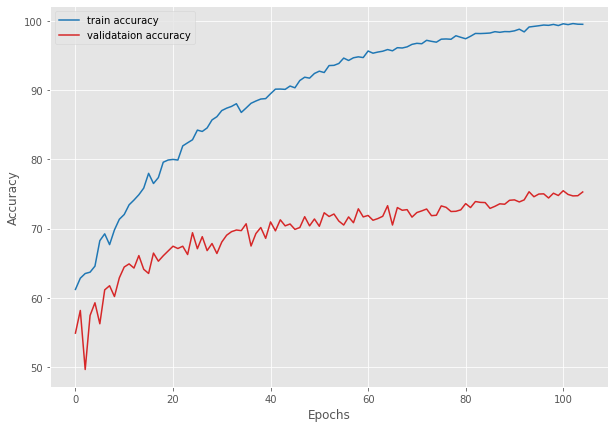

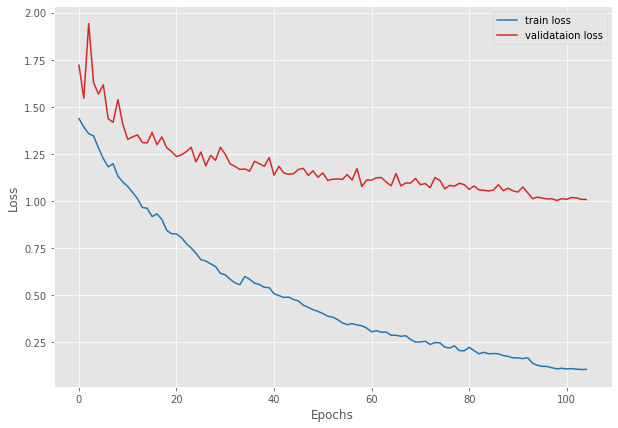

In [23]:
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)

In [25]:
# restored after interaption
tab = []